In [1]:
import io
import math
import cv2
import numpy as np
from IPython.display import Image, display
import PIL.Image

In [2]:
def showarray(a, fmt="jpeg", **kwargs):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue(), **kwargs))

In [3]:
def rotatedRectWithMaxArea(w, h, angle):
    """
  Given a rectangle of size wxh that has been rotated by 'angle' (in
  radians), computes the width and height of the largest possible
  axis-aligned rectangle (maximal area) within the rotated rectangle.
  """
    if w <= 0 or h <= 0:
        return 0, 0

    width_is_longer = w >= h
    side_long, side_short = (w, h) if width_is_longer else (h, w)

    # since the solutions for angle, -angle and 180-angle are all the same,
    # if suffices to look at the first quadrant and the absolute values of sin,cos:
    sin_a, cos_a = abs(math.sin(angle)), abs(math.cos(angle))
    if side_short <= 2.0 * sin_a * cos_a * side_long or abs(sin_a - cos_a) < 1e-10:
        # half constrained case: two crop corners touch the longer side,
        #   the other two corners are on the mid-line parallel to the longer line
        x = 0.5 * side_short
        wr, hr = (x / sin_a, x / cos_a) if width_is_longer else (x / cos_a, x / sin_a)
    else:
        # fully constrained case: crop touches all 4 sides
        cos_2a = cos_a * cos_a - sin_a * sin_a
        wr, hr = (w * cos_a - h * sin_a) / cos_2a, (h * cos_a - w * sin_a) / cos_2a

    return wr, hr

def rotate_bound(image, angle):
    # CREDIT: https://www.pyimagesearch.com/2017/01/02/rotate-images-correctly-with-opencv-and-python/
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    return cv2.warpAffine(image, M, (nW, nH))


def rotate_max_area(image, angle):
    """ image: cv2 image matrix object
        angle: in degree
    """
    wr, hr = rotatedRectWithMaxArea(image.shape[1], image.shape[0],
                                    math.radians(angle))
    rotated = rotate_bound(image, angle)
    h, w, _ = rotated.shape
    y1 = h//2 - int(hr/2)
    y2 = y1 + int(hr)
    x1 = w//2 - int(wr/2)
    x2 = x1 + int(wr)
    return rotated[y1:y2, x1:x2]

In [16]:
img = cv2.imread("test.jpg")

In [33]:
rot = rotate_max_area(img, 2)

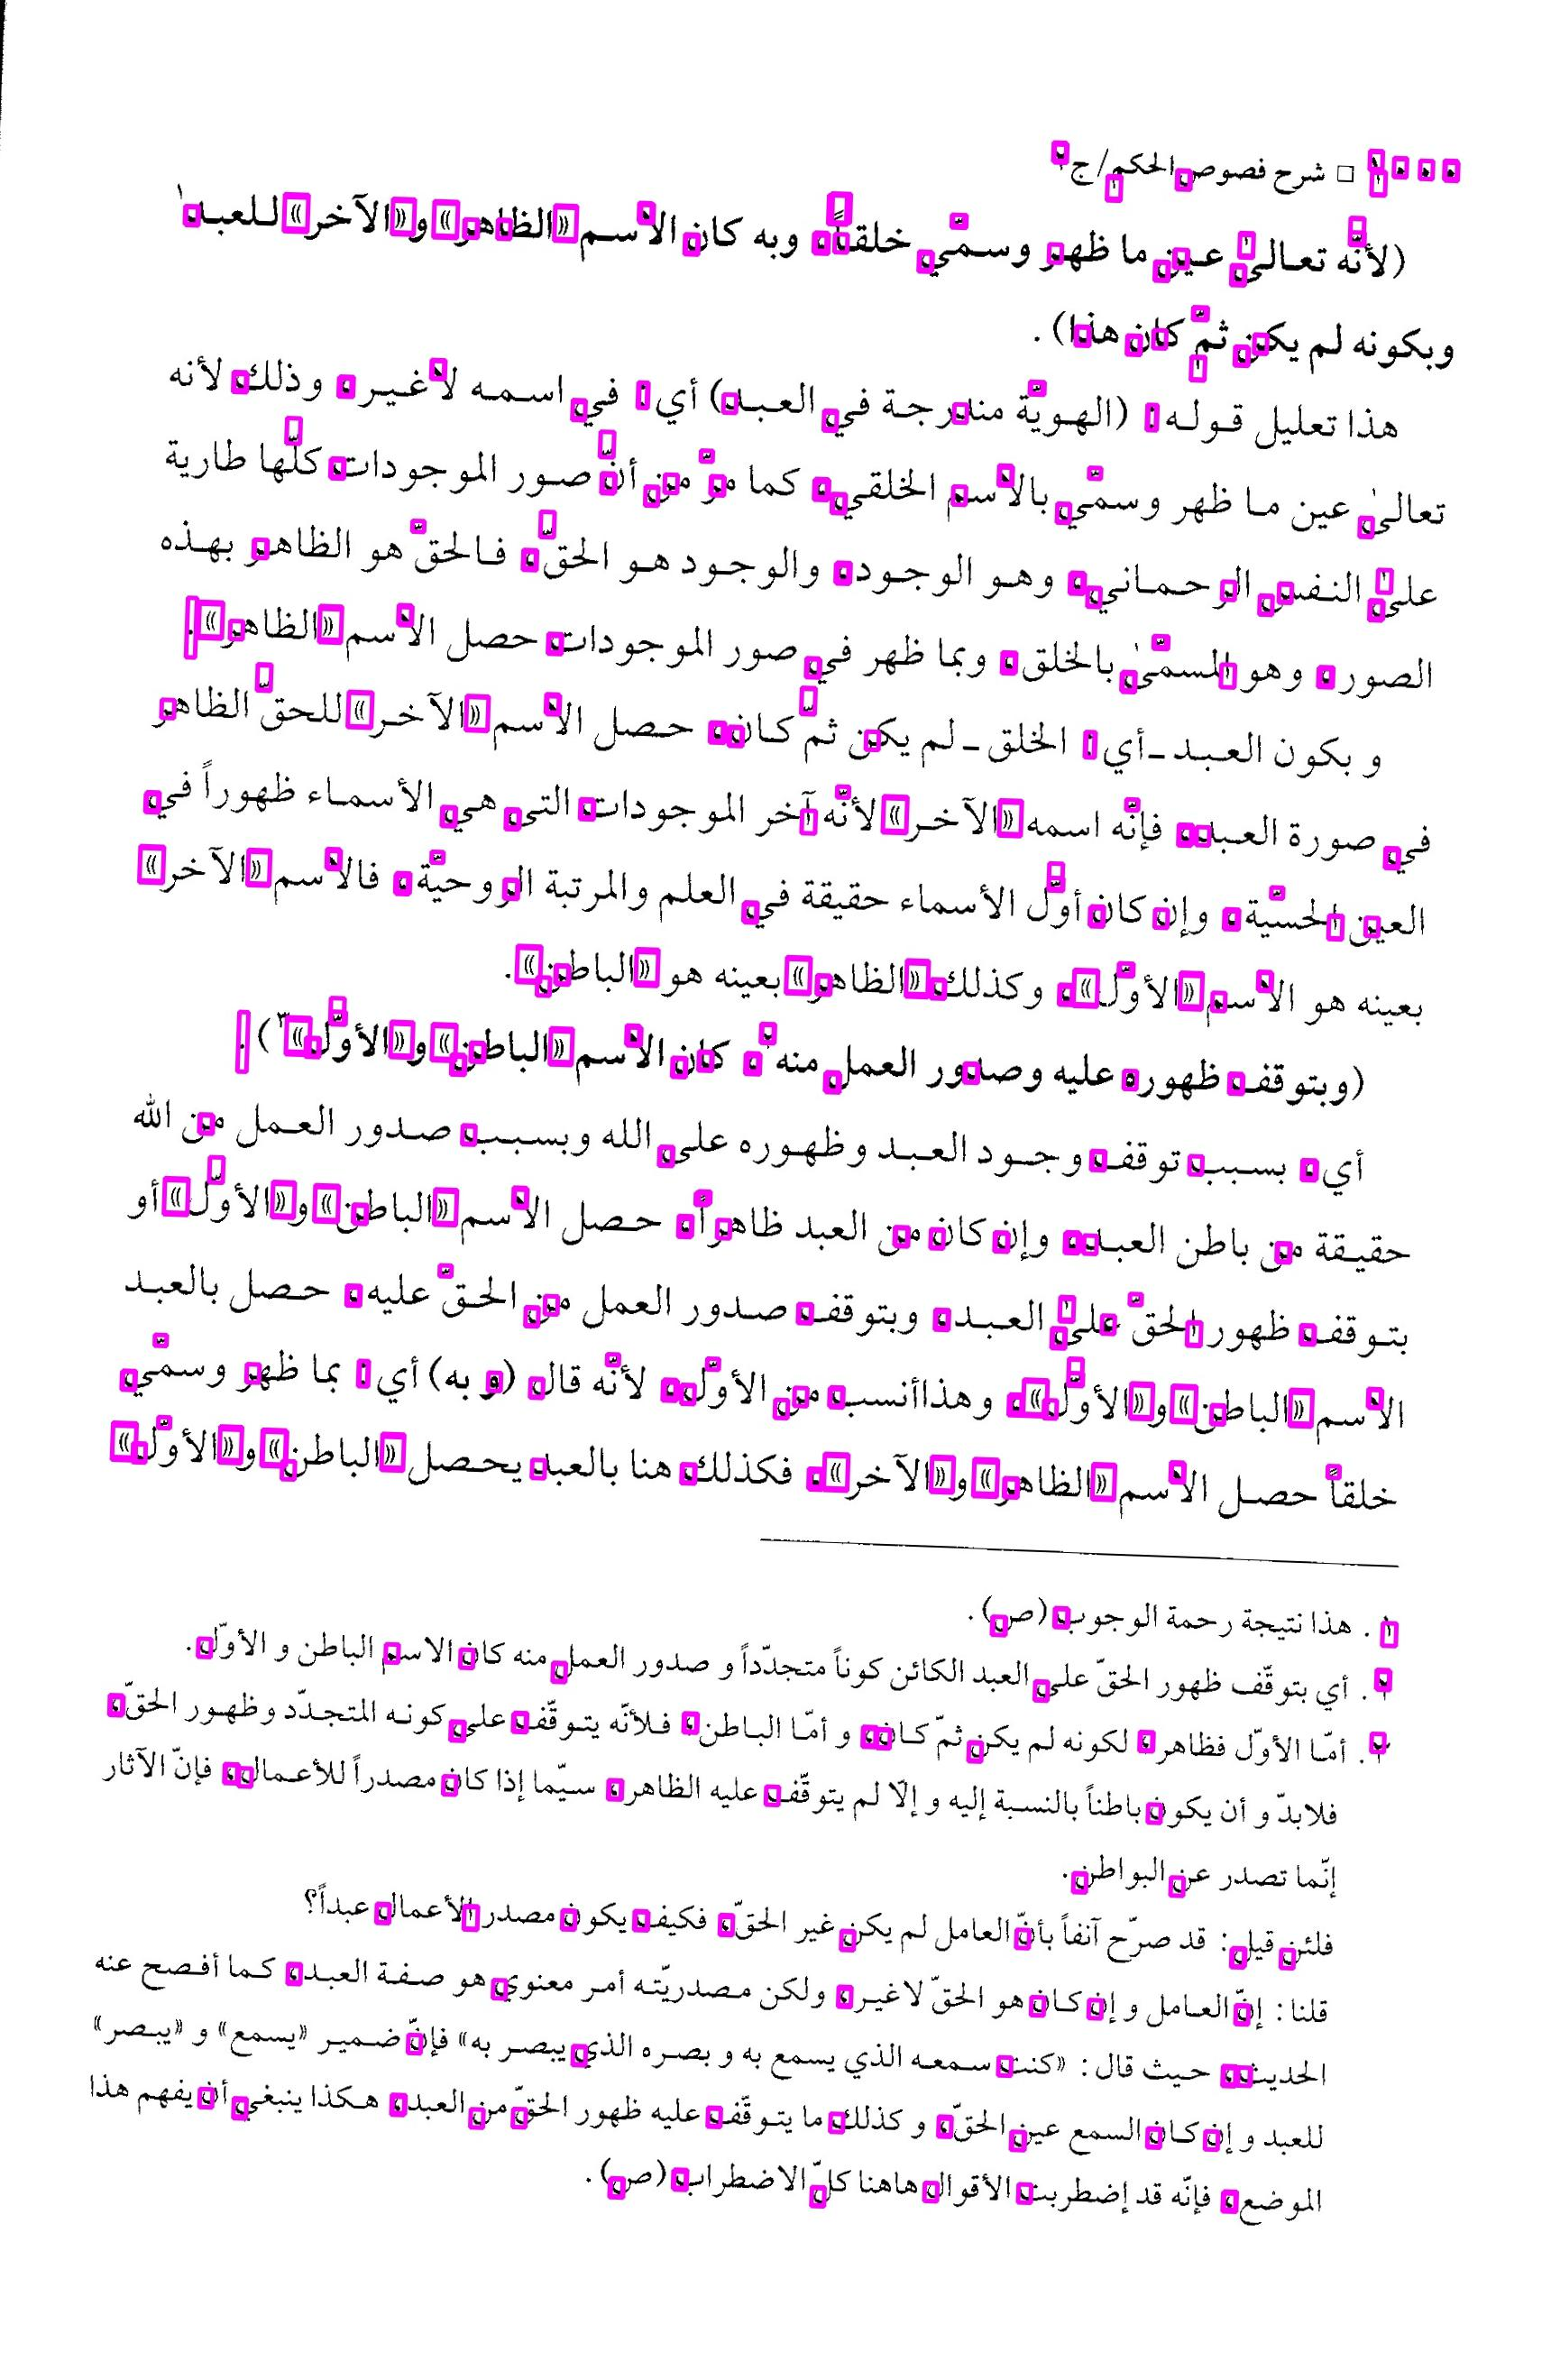

In [34]:
showarray(rot, width=400)